# Scanning Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()

from adamacs.pipeline import subject, session, surgery, scan, equipment
from adamacs import utility
from adamacs.ingest import session as isess
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())

[2023-02-26 20:01:10,673][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-02-26 20:01:10,731][INFO]: Connected tobiasr@172.26.128.53:3306


In [2]:
# subject.Subject.drop()
# subject.Mutation.drop()
# subject.Protocol.drop()
# subject.Line.drop()
# subject.SubjectGenotype.drop()
# equipment.Equipment.drop()
# scan.Scan.drop()
# session.Session.drop()
# imaging.Processing.drop()

In [3]:
# session.Session.delete()

In [4]:
scan.Scan.describe()

'-> session.Session\nscan_id              : varchar(12)                  \n---\n-> [nullable] equipment.Equipment\n-> scan.AcquisitionSoftware\nscan_notes=""        : varchar(4095)                # free-notes\n'

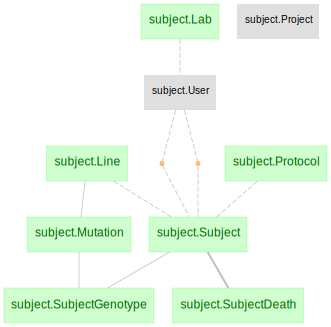

In [5]:
dj.Diagram(subject) + dj.Diagram(protocol)

Manual entry:

In [3]:
# Manual Entry
import datajoint as dj; import getpass
dj.config['database.host'] = '172.26.128.53'        # Put the server name between these apostrophe
dj.config['database.user'] = 'danielmk'             # Put your user name between these apostrophe
dj.config['database.password'] = getpass.getpass()  # Put your password in the prompt
dj.conn()

from adamacs.pipeline import subject, session, surgery, scan, equipment
from adamacs import utility
from adamacs.ingest import session as isess
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())


## Ingesting scan

Ingest all scans associated with a given session ID.

In [8]:
# isess.ingest_session_scan('sess9FB2LN5C', verbose=True)
isess.ingest_session_scan('sess9FGLZLRI', verbose=False) #TR: needs to be SessioID ("sess...")

DuplicateError: ("Duplicate entry 'TEC-sess9FGLZLRI' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [9]:
session.Session()

session_id,subject PyRat import uses this for earmark value,session_datetime
sess9FGLEFJ3,OPI-1681,2023-02-15 00:00:00
sess9FGLZLRI,OPI-1681,2023-02-16 00:00:00


In [44]:
session.SessionNote()

element_session.session_with_id.SessionNote

In [30]:
session.SessionDirectory() * session.ProjectSession() * sub

session_id,project,subject PyRat import uses this for earmark value,session_dir Path to the data directory for a session,user_id,earmark,sex Geschlecht,birth_date Geb.,death_date Gest.,generation Generation (F2 in example sheet),parent_ids dict of parent_sex: parent_eartag,owner_id,responsible_id,line strain_id within PyRAT. Not name_id seen in GUI,protocol
sess9FGLEFJ3,TEC,OPI-1681,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLEFJ3_sess9FGLEFJ3,7,T619,F,2022-05-10T00:00:00,None,,=BLOB=,1,2,376,81-02.04.2019.A192
sess9FGLZLRI,TEC,OPI-1681,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI,7,T619,F,2022-05-10T00:00:00,None,,=BLOB=,1,2,376,81-02.04.2019.A192
sess9FGLEFJ3,TEC,ROS-1438,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLEFJ3_sess9FGLEFJ3,7,G152,M,2022-06-22T13:34:48,2022-12-07T14:10:10,,=BLOB=,1,2,373,81-02.04.2019.A192
sess9FGLZLRI,TEC,ROS-1438,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI,7,G152,M,2022-06-22T13:34:48,2022-12-07T14:10:10,,=BLOB=,1,2,373,81-02.04.2019.A192
sess9FGLEFJ3,TEC,WEZ-8701,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLEFJ3_sess9FGLEFJ3,7,T453,M,2021-10-19T00:00:00,2022-09-19T19:51:53,,=BLOB=,1,2,376,01_Organentnahme
sess9FGLZLRI,TEC,WEZ-8701,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI,7,T453,M,2021-10-19T00:00:00,2022-09-19T19:51:53,,=BLOB=,1,2,376,01_Organentnahme


In [31]:
session.ProjectSession()

project,session_id
TEC,sess9FGLEFJ3
TEC,sess9FGLZLRI


In [32]:
key='scan9FG1UAQG'
(scan.Scan & f'scan_id=\"{key}\"')

session_id,scan_id,scanner,acq_software,scan_notes free-notes


Simple user look-up to get user_id from shorthand

In [34]:
key='RN'
query = (subject.User & f'initials=\"{key}\"')
id = query.fetch("user_id")[0]
print(key + ' = ' + str(id))

RN = 7


In [35]:
key='%Tob%'
query = (subject.User & f'name LIKE \"{key}\"')
id = query.fetch("user_id")
print(key + ' = ' + str(id))

%Tob% = [1]


In [36]:
key='%Ji%'
query = (subject.User & f'name LIKE \"{key}\"')
query.fetch("email")

array(['jjun1@uni-bonn.de'], dtype=object)

In [37]:
query = subject.Subject() & '"ROS-1380"'
query.fetch()

array([],
      dtype=[('subject', 'O'), ('earmark', 'O'), ('sex', 'O'), ('birth_date', 'O'), ('death_date', 'O'), ('generation', 'O'), ('parent_ids', 'O'), ('owner_id', '<i8'), ('responsible_id', '<i8'), ('line', '<i8'), ('protocol', 'O')])

In [38]:
subject.Subject() & "subject = 'ROS-1346'"

subject PyRat import uses this for earmark value,earmark,sex Geschlecht,birth_date Geb.,death_date Gest.,generation Generation (F2 in example sheet),parent_ids dict of parent_sex: parent_eartag,owner_id,responsible_id,line strain_id within PyRAT. Not name_id seen in GUI,protocol
